# (TRY FITTING FOR EACH CITY IN ANOTHER DOCUMENT

In [1]:
import os
import pandas as pd; pd.set_option('max_colwidth', None)
import numpy as np; np.random.seed(0)
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from datetime import datetime
from IPython.display import clear_output as co

from Classification import Classifier, plot_lc_model_comparison
# from NeuralNetwork import execute_neural_net, plot_learning_curve_comparison

from sklearn.metrics import classification_report as cr, confusion_matrix as cm

C:\Users\luisr\anaconda3\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


#### Defining functions

In [2]:
def target_categorical_distribution(X, Y, col='ID_TURMA'):
    minority_index = Y[Y==1].index
    turmas = X.loc[minority_index][col].unique()

    turma_counts = {}
    for i, turma in enumerate(turmas):
        if i%50==0: co(wait=True); print(f'{col} evaluated: {i+1}/{len(turmas)}')
        turma_counts[turma] = Y[X[col]==turma].value_counts()

    return pd.DataFrame(turma_counts).fillna(0)
# cnt.loc[1] = cnt.loc[1:2].sum(); cnt.drop([2,3], inplace=True) # transform target values in binary

In [3]:
def simetrical_categorical_sampler(X, Y, col='ID_TURMA', cnt=None):
    minority_index = Y[Y==1].index
    turmas = X.loc[minority_index][col].unique()
    if cnt is None: cnt = target_categorical_distribution(X, Y, col)
    X_0 = X[Y==0]
    XX = []
    for i, turma in enumerate(turmas):
        if i%50==0: co(wait=True); print(f'Turmas evaluated: {i+1}/{len(turmas)}')
        if cnt[turma][0]:
            if cnt[turma][0] < cnt[turma][1]: replace = True
            else: replace = False
            turma_0 = X_0[X_0[col]==turma]
            XX.append(turma_0.sample(cnt[turma].astype(int)[1], replace=replace))
    XX = pd.concat(XX)

    x_ = pd.concat([XX, X[Y==1]]).sample(len(XX)+(Y==1).sum())
    y_ = Y.loc[x_.index].copy()
    return x_, y_


In [4]:
def tts_categorical(x_, y_, cnt, test_size=0.2, col='ID_TURMA'):
    turmas_teste = cnt.T.sample(int(len(cnt.T)*test_size)).index.values
    test_index = x_[col].isin(turmas_teste)
    xe = x_[test_index].copy(); ye = y_.loc[test_index].copy()
    xt = x_[test_index==False].copy(); yt = y_.loc[test_index==False].copy()
    return xt, xe, yt, ye

In [5]:
def recursive_feature_inclusion(x, xe, y, ye, feature_importance, max_features=5, first_feature=1):
    scrs_df = []
    max_feat_i = range(first_feature, max_features+1)
    sorted_importance = feature_importance.sort_values(ascending=False)
    for i in max_feat_i:
        co(wait=True); print(f'Scoring model for {i}/{max_features} most important features.')
        sel_feat = sorted_importance.iloc[first_feature-1:i].index.values
        xt_s, xe_s = x[sel_feat], xe[sel_feat]
        yp_sel = model().fit(xt_s, y).predict(xe_s)
        scrs = cr(ye, yp_sel, output_dict=True)
        scrs_df.append([scrs['accuracy'], scrs['macro avg']['recall'], scrs['macro avg']['precision']])
    return pd.DataFrame(scrs_df, index=sorted_importance.iloc[first_feature-1:max_features].index, columns=['acc', 'recall', 'precision'])

In [6]:
def plot_rfi(rfe):
    fig, ax = plt.subplots(figsize=(6, 5.5), tight_layout=True)
    rfe.plot(marker='o', ax=ax)
    ax.set_xticks(range(len(rfe)))
    ax.set_xticklabels(rfe.index, rotation=90)
    ax.set(title='Recursive feature inclusion', xlabel='Feature', ylabel='Evaluation')
    plt.show()

#### Loading prepared data

In [7]:
data = pd.read_csv('data/grades/5th_grade.csv', index_col=0)

#### Loading Adapted Data Dictionaries

In [8]:
data_path = '/Users/luisr/Desktop/Repositories/Data/saep/CSV/{}'
grades = [5,9,3]; dict_filenames = [f'dicionario {i}ano.csv' for i in grades]
dicts = {grade: pd.read_csv(data_path.format(filename)).set_index('questão') for grade, filename in zip(grades, dict_filenames)}

#### Defining targets corresponding to each student grade

In [9]:
#### Define the target variable
targets = { # Abandonment
    5: 'TX_RESP_Q049',
    9: 'TX_RESP_Q050',
    12: 'TX_RESP_Q044',
}
grade = 5
target = targets[grade]

rep_targets = { # Reproval cols
    5: 'TX_RESP_Q048',
    9: 'TX_RESP_Q049',
    12: 'TX_RESP_Q043'
}
rep_target = rep_targets[grade]

#### List different types of features

In [10]:
ids = data.columns[:11].tolist()
questions = data.columns[11:65].tolist()
grades = data.columns[65:].tolist()

---
# TARGET VARIABLE TRANSFORMATION

### 2.2.1. Target Variable Classes Transformation


Obs: Last label represent missing values (Label 3)

In [11]:
def binary(Y, out, replace):
    # 1. Droping rows where the target variable is missing 
    # 2. Target variable conversion to binary
    labels = list(replace.keys())
    label_map = lambda label: (replace[label] if label in labels else label)
    return Y[Y.isin(out)==False].map(label_map)

### Defining X and Y

In [12]:
Y = binary(data[target].copy(), out=[3], replace={2: 1})
X = data.loc[Y.index].drop(target, 1)

In [13]:
Y.value_counts()

0    397232
1     50087
Name: TX_RESP_Q049, dtype: int64

---
# MISSING VALUES STRATEGY

In [14]:
for grade in grades:
    X[grade].fillna(X[grade].mean(), inplace=True)

---
# DATA SAMPLING

#### Approximately 60000 (12,8 % of students) students from school classes without any student who has already dropped out school at any point and returned. Against 408000 students which have a student coleague in the same school class who has dropped out. 

# Sample equal number of students for each class for each schol class

In [15]:
cnt = target_categorical_distribution(X, Y, col='ID_MUNICIPIO')

ID_MUNICIPIO evaluated: 1001/1034


In [16]:
x_, y_ = simetrical_categorical_sampler(X, Y, col='ID_MUNICIPIO', cnt=cnt)

Turmas evaluated: 1001/1034


In [17]:
y_.value_counts()

1    50087
0    50087
Name: TX_RESP_Q049, dtype: int64

# Train test split based on school classes

In [36]:
x, xe, y, ye = tts_categorical(x_, y_, cnt, test_size=0.93, col='ID_MUNICIPIO')

### Training class count

In [37]:
y.value_counts()

1    2312
0    2312
Name: TX_RESP_Q049, dtype: int64

### Test percentage

In [38]:
xe.shape[0] / x.shape[0]

20.66392733564014

---
# FEATURE SELECTION

In [39]:
from sklearn.utils import all_estimators

model_name = 'GradientBoostingClassifier'
classifiers = dict(all_estimators('classifier'))
model = classifiers[model_name]

In [40]:
out_models = [
    'CategoricalNB', 'ClassifierChain', 'OneVsRestClassifier',
    'MultiOutputClassifier', 'VotingClassifier', 'StackingClassifier',
    'OutputCodeClassifier', 'OneVsOneClassifier', 'RadiusNeighborsClassifier',
    'GaussianProcessClassifier'
]
models = list(set(list(classifiers.keys())).difference(out_models))

In [49]:
models = [
    'RandomForestClassifier','RidgeClassifier','LinearDiscriminantAnalysis',
    'RidgeClassifierCV', 'AdaBoostClassifier', 'ExtraTreesClassifier',
    'GradientBoostingClassifier', 'HistGradientBoostingClassifier'
]

# Optimizing sampling

#### Optimizing target class proportion

In [57]:
min_size_scrs = minority_percentage_score(x, y, model, p_min=0.3, p_max=2, n=9, test_size=0.9, col='ID_MUNICIPIO')

Turmas evaluated: 201/207


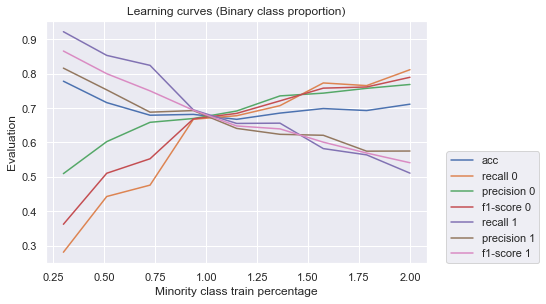

In [58]:
min_size_scrs.plot(); plt.tight_layout()
plt.title('Learning curves (Binary class proportion)')
plt.xlabel('Minority class train percentage');
plt.ylabel('Evaluation')
plt.legend(loc=(1.05,0))
plt.show()

# Visualizing selected models test data learning curves 

In [50]:
train_size_scrs = Classifier().train_size_scr(
    list(reversed(models)), x, y, xe, ye,
    batch_size=None, n=5, order=2,
    scoring=['accuracy', 'precision', 'recall']
)

RandomForestClassifier


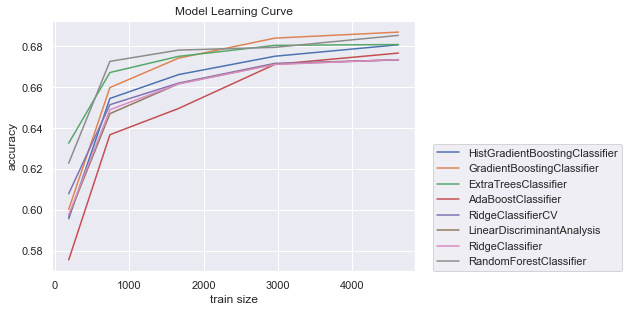

In [51]:
plot_lc_model_comparison(
    train_size_scrs, metric='accuracy',
    avg_window=1, min_periods=1, center=False,
    figsize=(9, 4.5), legend=True, leg_loc=(1.05, 0),
    title='Model Learning Curve', tight_layout=True, path=None
)

# Evaluate models using cross validation

In [47]:
cv_scrs = Classifier().cv_scr(models, x, y, cv=5)

In [48]:
co(wait=True); cv_scrs.T.sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
RandomForestClassifier,5.0,0.681878,0.006025,0.674595,0.678919,0.680000,0.686147,0.689730
RidgeClassifier,5.0,0.675608,0.010358,0.660541,0.670270,0.680000,0.680000,0.687229
LinearDiscriminantAnalysis,5.0,0.675391,0.009574,0.661622,0.669189,0.681081,0.681081,0.683983


# Fit and score baseline model

#### City sampling

In [52]:
model_fit = model().fit(x, y)
print(cr(ye, model_fit.predict(xe)))

              precision    recall  f1-score   support

           0       0.68      0.70      0.69     47775
           1       0.69      0.67      0.68     47775

    accuracy                           0.69     95550
   macro avg       0.69      0.69      0.69     95550
weighted avg       0.69      0.69      0.69     95550



# Retrieve feature importance

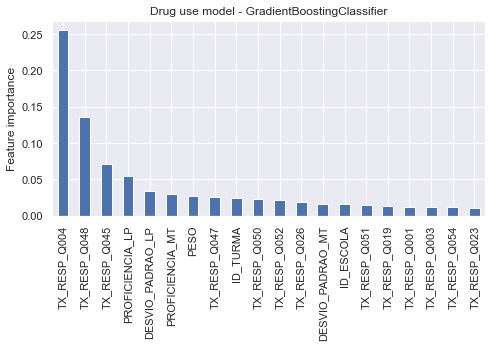

In [54]:
feature_importance = pd.Series(model_fit.feature_importances_, index=X.columns).sort_values(ascending=False)

first, n_first = 1, 25
fig, ax = plt.subplots(figsize=(7,5), tight_layout=True)
feature_importance.iloc[first-1:n_first].plot.bar(ax=ax);
plt.title(f'Drug use model - {model_name}');
plt.ylabel('Feature importance'); plt.show()

# Fit and scorE baseline model up to max_features=15 most import features

In [55]:
RFI = recursive_feature_inclusion(x, xe, y, ye, feature_importance, max_features=15, first_feature=1)

Scoring model for 15/15 most important features.


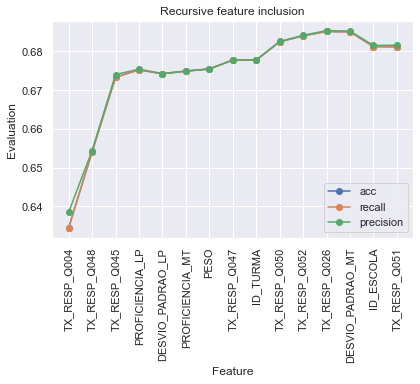

In [56]:
plot_rfi(RFI)

# Classification report for baseline model of selected features

In [58]:
selected_features = feature_importance[:4].index.values
xt_s = x[selected_features]; xe_s = xe[selected_features]
yp_sel = model().fit(xt_s, y).predict(xe_s)

print(cr(ye, yp_sel))

              precision    recall  f1-score   support

           0       0.67      0.69      0.68     47775
           1       0.68      0.66      0.67     47775

    accuracy                           0.68     95550
   macro avg       0.68      0.68      0.68     95550
weighted avg       0.68      0.68      0.68     95550



# Understanding selected features

In [323]:
selected = [
    'TX_RESP_Q004', 'TX_RESP_Q048',
    'TX_RESP_Q045', 'TX_RESP_Q050',
#     'TX_RESP_Q051', 'TX_RESP_Q052',
#     'TX_RESP_Q015', 'TX_RESP_Q053',
#     'TX_RESP_Q003', 'TX_RESP_Q040',
#     'TX_RESP_Q047', 'TX_RESP_Q027',
#     'TX_RESP_Q026'
#     'TX_RESP_Q018', 'TX_RESP_Q015'
]

In [324]:
pd.concat([dicts[5].loc[[col]] for col in selected]).T.dropna(how='all').replace(np.nan, '')

questão,TX_RESP_Q004,TX_RESP_Q048,TX_RESP_Q045,TX_RESP_Q050
Enunciado,Qual a sua idade?,Você já foi reprovado?,Você trabalha fora de casa?,Você faz o dever de casa de língua portuguesa?
A,8 anos ou menos.,Não.,Sim.,Sempre ou quase sempre.
B,9 anos.,"Sim, uma vez.",Não.,De vez em quando.
C,10 anos.,"Sim, duas vezes ou mais.",,Nunca ou quase nunca.
D,11 anos.,,,
E,12 anos.,,,
F,13 anos.,,,
G,14 anos.,,,
H,15 anos ou mais,,,


# RECURSIVE FEATURE ELIMINATION

In [66]:
from sklearn.feature_selection import RFE, RFECV, SequentialFeatureSelector as SFS

In [ ]:
rfe = RFE(model(), n_features_to_select=1, step=1, verbose=1)
rfe.fit(x[feature_importance.iloc[:30].index], y)

In [69]:
rfe_features = pd.Series(feature_importance.iloc[:30].index, index=rfe.ranking_).sort_index()
rfe_features.head(10)

1         TX_RESP_Q048
2         TX_RESP_Q004
3      PROFICIENCIA_LP
4         TX_RESP_Q045
5     DESVIO_PADRAO_MT
6             ID_TURMA
7         TX_RESP_Q050
8         ID_MUNICIPIO
9         TX_RESP_Q027
10                PESO
dtype: object

# RECURSIVE FEATURE ELIMINATION (with built-in cross validation)

---
# BINARY CLASSIFICATION MODELS USING NEURAL NETWORKS

In [288]:
import torch
import torch.nn as nn

In [96]:
xt.shape

(80139, 73)

In [ ]:
nn_params = {
    'test_size': 0.3,
    'hidden_layers': [78, 78, 78],
    'initial_params': {'weight': 0, 'bias': 0},
    # 'criterion': None
    'optimizer': torch.optim.SGD,
    'activation': 'relu',
    'epochs': 15000,
    'batch_size': 100,
    'lr': 0.1,
    'momentum': 0,
}

criteria_dict = {
    'BCELoss': nn.BCELoss,
    'L1Loss': nn.L1Loss,
    'MSELoss': nn.MSELoss,
    'HuberLoss': nn.HuberLoss
}

eval_i = {}
for label, criteria in criteria_dict.items():
    eval_i[label] = execute_neural_net(
        xt, yt, xe, ye,
        criterion=criteria,
        **nn_params,
    )

### Comparing neural network test predictions for different loss functions

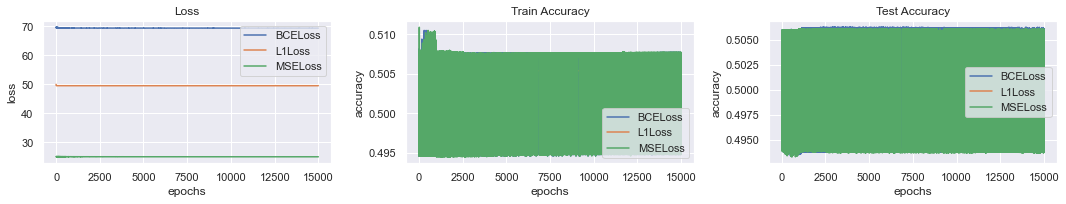

In [747]:
plot_learning_curve_comparison(eval_i, figsize=(15,3), tight_layout=True, legend=True)

In [758]:
grades

['PESO',
 'PROFICIENCIA_LP',
 'DESVIO_PADRAO_LP',
 'PROFICIENCIA_LP_SAEB',
 'DESVIO_PADRAO_LP_SAEB',
 'PROFICIENCIA_MT',
 'DESVIO_PADRAO_MT',
 'PROFICIENCIA_MT_SAEB',
 'DESVIO_PADRAO_MT_SAEB']